## Hex GNN Experimentation

In [94]:
NUMAGENTS = 30
NUMEXPERIMENTS = 150  #10
TIME = 10 # seconds #25
VISUAL = False

In [95]:
import simulation.Visualizer
import simulation.World
import simulation.Agent
import pickle
from matplotlib import pyplot as plt

In [96]:

simulation.Agent.USE = "SIM"
simulation.Agent.CASE = "HEX"

for i in range(NUMEXPERIMENTS):
    if i%10== 0:
        print(str(i)+"/"+str(NUMEXPERIMENTS))
    filename = "./data_new/hex-logs/experiment-"+str(i)+"-log.p"
    with open(filename, "wb") as f:
        world = simulation.World.World(f)
        for j in range(int(NUMAGENTS)):
            a = simulation.Agent.Agent(swarm=j%2)
            world.agents.append(a)

        if VISUAL:
            v = simulation.Visualizer.Visualizer(world)
            v.run()
        else:
            while world.stepCount < TIME*10:
                world.step()
            world.closeWorld()

0/150
10/150
20/150
30/150
40/150
50/150
60/150
70/150
80/150
90/150
100/150
110/150
120/150
130/150
140/150


In [97]:
import utils.HexDataset
import shutil

###############################
###  Gather and split data  ###
###############################

ta = 70 # Percentage used for training (remaining used for testing)

try:
    shutil.rmtree("/tmp/Hexs", ignore_errors=False, onerror=None)
except FileNotFoundError as e:
    pass
    
dataset = utils.HexDataset.HexDataset(root='/tmp/Hexs').shuffle()

train_data = dataset[0:int(ta/100.*len(dataset))]
test_data = dataset[int(ta/100.*len(dataset)):]

print(dataset[0])

Processing...


150
File: 0
File: 1
File: 2
File: 3
File: 4
File: 5
File: 6
File: 7
File: 8
File: 9
File: 10
File: 11
File: 12
File: 13
File: 14
File: 15
File: 16
File: 17
File: 18
File: 19
File: 20
File: 21
File: 22
File: 23
File: 24
File: 25
File: 26
File: 27
File: 28
File: 29
File: 30
File: 31
File: 32
File: 33
File: 34
File: 35
File: 36
File: 37
File: 38
File: 39
File: 40
File: 41
File: 42
File: 43
File: 44
File: 45
File: 46
File: 47
File: 48
File: 49
File: 50
File: 51
File: 52
File: 53
File: 54
File: 55
File: 56
File: 57
File: 58
File: 59
File: 60
File: 61
File: 62
File: 63
File: 64
File: 65
File: 66
File: 67
File: 68
File: 69
File: 70
File: 71
File: 72
File: 73
File: 74
File: 75
File: 76
File: 77
File: 78
File: 79
File: 80
File: 81
File: 82
File: 83
File: 84
File: 85
File: 86
File: 87
File: 88
File: 89
File: 90
File: 91
File: 92
File: 93
File: 94
File: 95
File: 96
File: 97
File: 98
File: 99
File: 100
File: 101
File: 102
File: 103
File: 104
File: 105
File: 106
File: 107
File: 108
File: 109
File: 

Done!


Data(x=[30, 2], edge_index=[2, 58], y=[1, 2])


In [98]:
dataset[0].y

tensor([[-0.0221,  0.0393]])

In [99]:
dataset[0].x

tensor([[ 0.0000e+00,  0.0000e+00],
        [-3.1081e-01, -2.0225e-01],
        [-2.4866e-01, -3.1655e-01],
        [ 6.6930e-02, -2.3055e-01],
        [-2.3712e-01,  1.1622e-01],
        [ 2.7084e-01, -1.8643e-01],
        [-6.6636e-05, -2.7826e-01],
        [ 3.7045e-02, -1.0692e-01],
        [-2.0191e-01, -1.5324e-01],
        [ 1.5618e-01, -1.2656e-01],
        [ 1.3724e-01, -8.8675e-03],
        [ 1.2053e-01,  1.6219e-01],
        [ 1.0577e-01,  6.4171e-02],
        [-3.0919e-01,  2.2633e-01],
        [ 3.2442e-02,  2.4760e-01],
        [ 3.3447e-01,  3.0900e-01],
        [ 3.1630e-01,  4.5611e-02],
        [ 2.1443e-01,  3.5262e-01],
        [ 1.6970e-01, -2.5180e-01],
        [-1.9735e-01, -1.1834e-02],
        [-9.6451e-04,  1.2566e-01],
        [-2.1739e-01,  3.0896e-01],
        [ 2.7361e-01, -6.6975e-02],
        [-3.1135e-01,  3.7986e-01],
        [ 3.8525e-01, -2.2568e-01],
        [-1.0846e-01, -2.2438e-01],
        [-1.0709e-01, -3.4600e-01],
        [-1.0384e-01,  6.261

In [100]:
from torch_geometric.data import Data, DataLoader
from utils.models import *
from tqdm import tqdm
import numpy as np
import torch
from time import sleep

np.random.seed(2022)

num_epochs = 200
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size=32
trainLoader = DataLoader(train_data, batch_size=32, shuffle=True)
testLoader = DataLoader(test_data, batch_size=32, shuffle=True)

node_dim = train_data[0].x.shape[1]
edge_dim = 0
if train_data[0].edge_attr: # if edge attributes used
    edge_dim = train_data[0].edge_attr.shape[1]
out_dim = train_data[0].y.shape[1]

In [101]:
import math
from random import random

def showProgressGraphs(generator):
    xs = 0.07
    xe = 0.4

    MULT = 1
    TARGET_DIST = 0.15 
    DIP = 1 

    def lj(x, e):

        dist = math.sqrt(((x[1][0]-x[0][0])**2)+((x[1][1]-x[0][1])**2))
        epsilon = DIP*MULT
        sigma = (TARGET_DIST*MULT)/(2**(1/6))
        mag = min((epsilon*4) * (pow((sigma/dist),12)-pow((sigma/dist),6)), 10)

        angle = math.pi
        if mag > 0:
            angle = 0

        return mag, angle


    numScatter = 5000
    numPoints = 1000
    delta = (1/numPoints)*(xe-xs)

    plotDataX = []
    plotDataPredY = []
    plotDataPredA = []
    plotDataPredX = []
    plotDataActY = []
    plotDataActA = []
    plotDataEqnY = []


    for i in range(numPoints):

        data = [[0, 0], [0, 0]]
        xVal = delta*i+delta + xs
        data[1] = [xVal, 0]
        plotDataX.append(xVal)

        e1 = [0, 1]
        e2 = [1, 0]

        x = torch.tensor(data, dtype=torch.float)
        e = torch.tensor([e1, e2], dtype=torch.long)

        actualMag, actualAng = lj(x, e)

        plotDataActY.append(actualMag)
        plotDataActA.append(math.degrees(actualAng))

    pois = []

    for i in range(numScatter):

        data = [[0, 0] for _ in range(2)]
        ox = random()
        oy = random()
        d = (random()*(xe-xs)+xs)
        a = random() * (2*math.pi)
        no = ox + d*math.cos(a)
        ny = oy + d*math.sin(a)

        data[0] = [ox, oy]
        data[1] = [no, ny]
        e1 = [0, 1]
        e2 = [1, 0]
        
        x = torch.tensor(data, dtype=torch.float).to(device)
        e = torch.tensor([e1, e2], dtype=torch.long).to(device)
        batch=torch.tensor(np.zeros((len(x),1)),dtype=torch.long).to(device)
        pred = generator(x, e,batch=batch)

        ljMag, ljAng = lj(x, e)
        pois.append([ox, oy, no, ny, pred[0][0], pred[0][1], d])

        mag = math.sqrt((pred[0][0])**2 + (pred[0][1])**2)
        ang = abs(math.degrees(math.atan2(pred[0][1], pred[0][0]) - math.atan2(oy-ny, ox-no)))

        actAng  = math.degrees(ljAng)

        if ang < 90: # clip ang to 0
            mag = mag
        else: # clip ang to 180
            mag = -mag

        plotDataPredX.append(d)
        plotDataPredA.append(abs(actAng-ang))
        plotDataPredY.append(mag)
    #    plotDataEqnY.append(eqnMag)

    plt.rcParams['figure.figsize'] = [12, 3]
    plt.rcParams['figure.dpi'] = 200 # 200 e.g. is really fine, but slower

    fig, (ax1, ax2) = plt.subplots(1,2)

    ys = -1.5* MULT
    ye = 1.2*MULT

    ax1.plot(plotDataX, plotDataActY, label='Actual Output from LJ Potential')
    ax1.scatter(plotDataPredX, plotDataPredY, s=1, color=[1, 0, 0], alpha=0.1, label='Predicted by GNN of 20 agents')
    ax1.set_xlim([xs, xe])
    ax1.set_ylim([ys, ye])
    ax1.plot([xs, xe], [0, 0], 'k--')
    ax1.legend()
    ax1.set_xlabel("Distance Between Two Agents (World Units)")
    ax1.set_ylabel("Magnitude of Acceleration")
    
    ax2.plot(plotDataX, plotDataActA, 'k--')
    ax2.scatter(plotDataPredX, plotDataPredA, s=1, color=[1, 0, 0], alpha=0.1, label='Predicted by GNN of 20 agents')
    ax2.set_xlim([xs, xe])
    ax2.set_ylim([-5, 185])
    ax2.plot([xs, xe], [0, 0], 'k--')
    ax2.plot([xs, xe], [180, 180], 'k--')
    ax2.set_xlabel("Distance Between Two Agents (World Units)")
    ax2.set_ylabel("Angle Error of Acceleration (deg)")

    ax1.set_title('Magnitude of Force (Hexagonal)')
    ax2.set_title('Angle Error (Hexagonal)')     

    plt.show()

In [102]:
import numpy as np
import torch
from torch_geometric.nn import MessagePassing
from torch.nn import Sequential as Seq, Linear as Lin, Sigmoid as Sig, ReLU,Tanh
from torch_scatter import scatter
import torch
import torch.nn as nn
import torch.nn.functional as F

# class Comparator(nn.Module):
#     def __init__(self):
#         super(Comparator, self).__init__()
#         self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1)
# #         self.conv2 = nn.Conv2d(32, 64, 1, 1)
#         self.dropout1 = nn.Dropout2d(0.25)
#         self.dropout2 = nn.Dropout2d(0.5)
#         self.fc1 = nn.Linear(480, 128)
#         self.fc2 = nn.Linear(128, 1)

#     # x represents our data
#     def forward(self, x):
#         x = self.conv1(x[None,None,...])
#         x = F.relu(x)
# #         x = self.conv2(x)
# #         x = F.relu(x)
#         x = F.max_pool2d(x, 2)
#         x = self.dropout1(x)
#         x = torch.flatten(x, 1)
#         x = self.fc1(x)
#         x = F.relu(x)
#         x = self.dropout2(x)
#         x = self.fc2(x)
        
#         return F.sigmoid(x)
#         #         return self.result

class Discriminator(MessagePassing):
    
    def __init__(self, node_dim, out_dim, edge_dim=0, msg_dim=100, hidden=150, aggr='add'):
        
        super(Discriminator, self).__init__(aggr=aggr)  # "Add" aggregation.
 
        self.msg_fnc = Seq(
            Lin(2*node_dim+edge_dim, hidden),
            ReLU(),
            Lin(hidden, hidden),
            ReLU(),
            Lin(hidden, hidden),
            ReLU(),
            Lin(hidden, msg_dim)
        )
        
        self.node_fnc = Seq(
            Lin(msg_dim+node_dim, hidden),
            ReLU(),
            Lin(hidden, hidden),
            ReLU(),
            Lin(hidden, hidden),
            ReLU(),
            Lin(hidden, out_dim)
        )
        
        self.comparator=Seq(
            Lin(2*node_dim, 4*node_dim),
            ReLU(),
            Lin(4*node_dim, 4*node_dim),
            ReLU(),
            Lin(4*node_dim, 1),
            Sig()
        )
        
    def forward(self, init_graph,y,edge_index, edge_attr=None, batch=None):
        if edge_attr:
            result = self.propagate(edge_index, x=init_graph, edge_attr=edge_attr)
        else:
            result = self.propagate(edge_index, x=init_graph)
            
        result = scatter(result, batch.reshape((-1,1)), dim=0)
        result=torch.cat([result,y],dim=1)
#         print(result.shape)
        return self.comparator(result)
        
    def message(self, x_i, x_j, edge_attr=None):
        if edge_attr:
            tmp = torch.cat([x_i, x_j, edge_attr], dim=1)
        else:
            tmp = torch.cat([x_i, x_j], dim=1)
        return self.msg_fnc(tmp)
    
    def update(self, aggr_out, x=None):
        tmp = torch.cat([x, aggr_out], dim=1)
        return self.node_fnc(tmp)
    
    def loss(self, actual, pred):
        return torch.sum(torch.abs(actual - pred))


class Generator(MessagePassing):
    
    def __init__(self, node_dim, out_dim, edge_dim=0, msg_dim=100, hidden=300, aggr='mean'):
        
        super(Generator, self).__init__(aggr=aggr)  # "Add" aggregation.
 
        self.msg_fnc = Seq(
            Lin(2*node_dim+edge_dim, hidden),
            ReLU(),
            Lin(hidden, hidden),
            ReLU(),
            Lin(hidden, hidden),
            Tanh(),
            Lin(hidden, msg_dim)
        )
        
        self.node_fnc = Seq(
            Lin(msg_dim+node_dim, hidden),
            ReLU(),
            Lin(hidden, hidden),
            ReLU(),
            Lin(hidden, hidden),
            Tanh(),
            Lin(hidden, out_dim)
        )
            
    def forward(self, x, edge_index, edge_attr=None, batch=None):
        if edge_attr:
            result = self.propagate(edge_index, x=x, edge_attr=edge_attr)
        else:
            result = self.propagate(edge_index, x=x)
        #print(result.shape)
#         print(batch.shape)
        result = scatter(result, batch.reshape((-1,1)), dim=0, reduce="mean")
        
        return result
    
    def message(self, x_i, x_j, edge_attr=None):
        if edge_attr:
            tmp = torch.cat([x_i, x_j, edge_attr], dim=1)
        else:
            tmp = torch.cat([x_i, x_j], dim=1)
        return self.msg_fnc(tmp)
    
    def update(self, aggr_out, x=None):
        tmp = torch.cat([x, aggr_out], dim=1)
        return self.node_fnc(tmp)
    
    def loss(self, actual, pred):
        return torch.sum(torch.abs(actual - pred))
    
from torch import nn, optim
from torch.autograd.variable import Variable

D = Discriminator(node_dim,out_dim)
G = Generator(node_dim, out_dim)
# C=  Comparator()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

D.to(device)
G.to(device)
# C.to(device)

d_optimizer = optim.Adam(D.parameters(), lr=1e-3, weight_decay=5e-7)
g_optimizer = optim.Adam(G.parameters(), lr=1e-3, weight_decay=5e-7)
# c_optimizer = optim.Adam(C.parameters(), lr=1e-3, weight_decay=5e-7)
loss = nn.BCELoss()

In [103]:
node_dim

2

In [104]:
out_dim

2

  0%|                                                                                                                                                                                                              | 0/30 [00:00<?, ?it/s]

|D_loss|0.004489337094128132	|G_loss|4.783766269683838


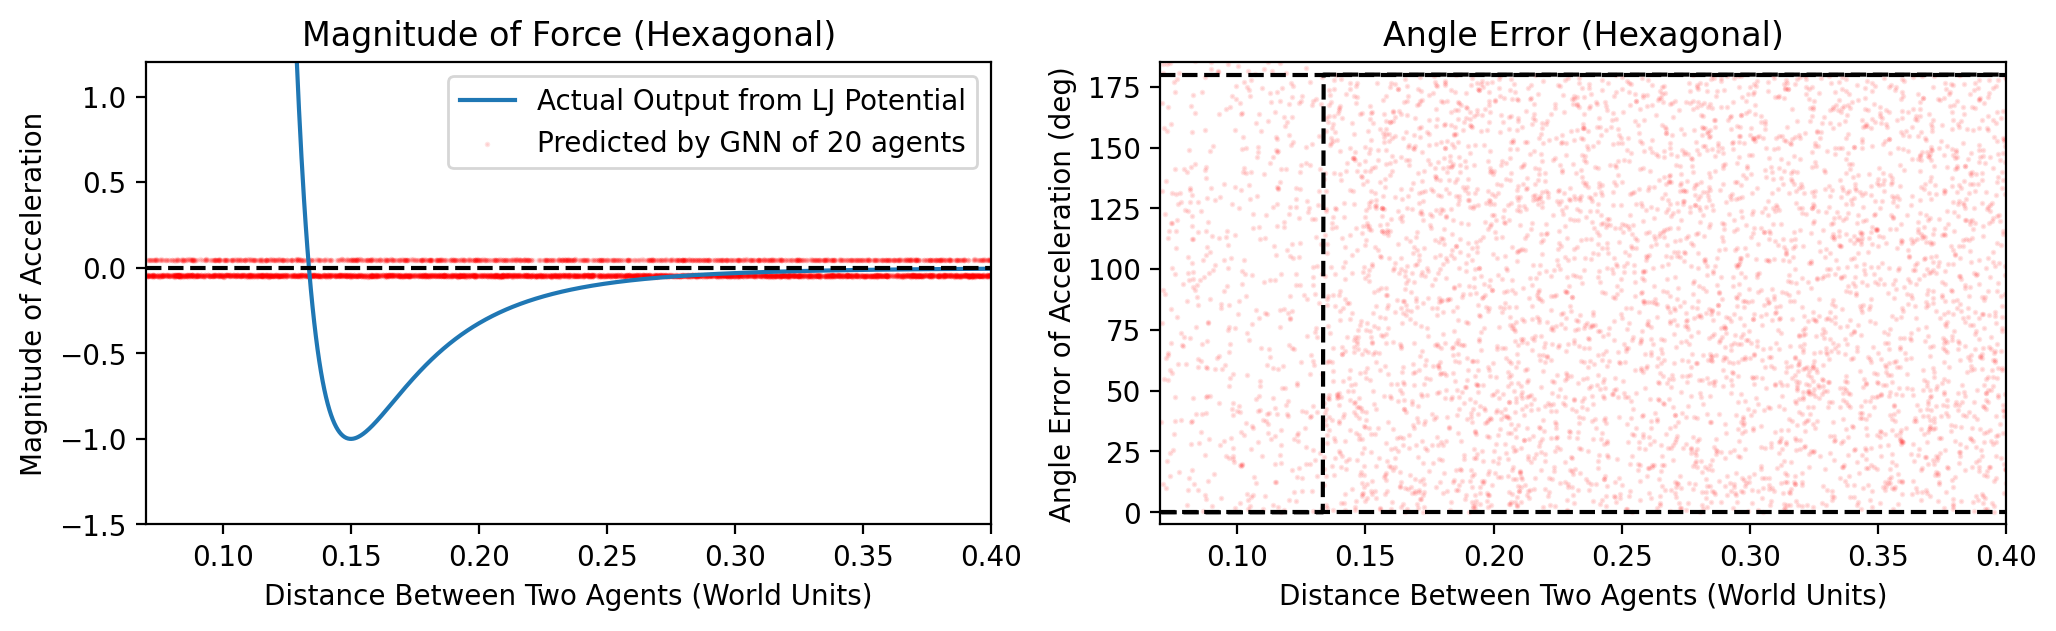

  3%|██████▌                                                                                                                                                                                            | 1/30 [09:07<4:24:40, 547.62s/it]

|D_loss|0.0003477073914837092	|G_loss|7.278926372528076


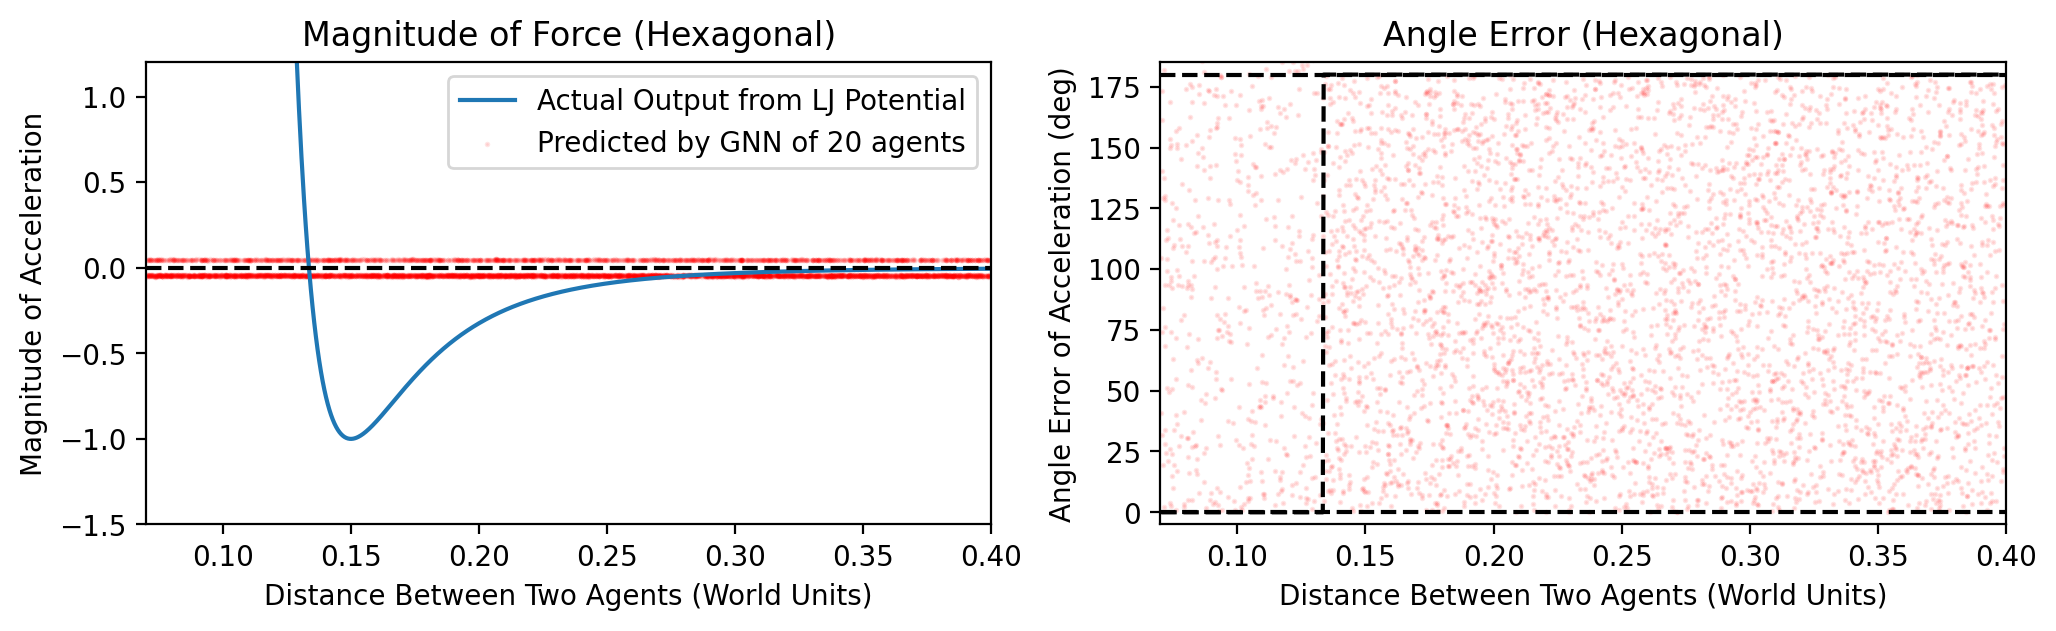

  7%|█████████████                                                                                                                                                                                      | 2/30 [19:29<4:35:54, 591.23s/it]

|D_loss|0.04693195968866348	|G_loss|6.947231292724609


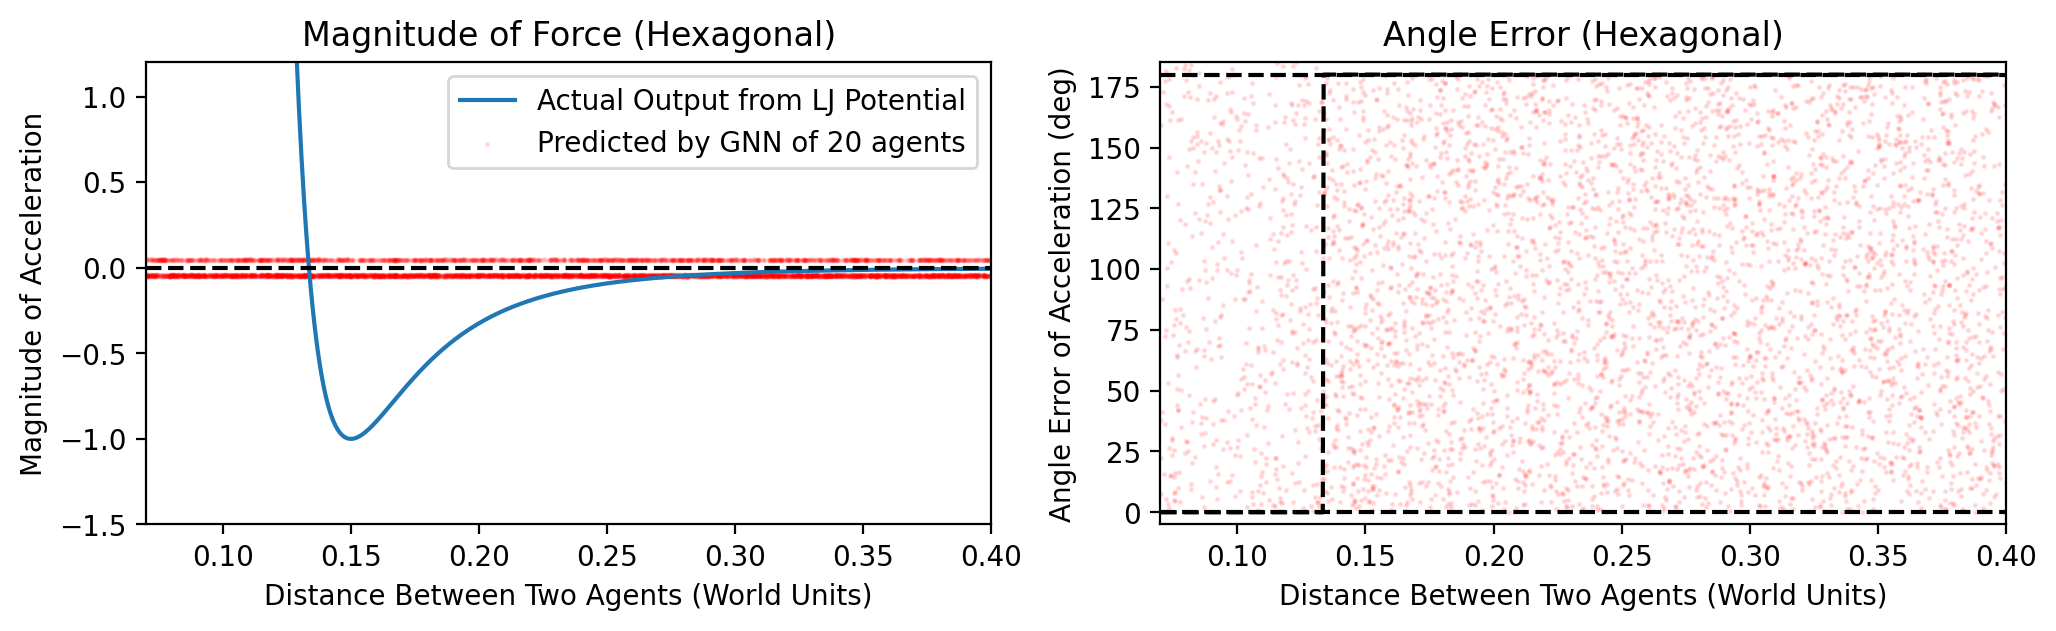

 10%|███████████████████▌                                                                                                                                                                               | 3/30 [29:07<4:23:24, 585.33s/it]

|D_loss|0.0008779505151323974	|G_loss|6.437076091766357


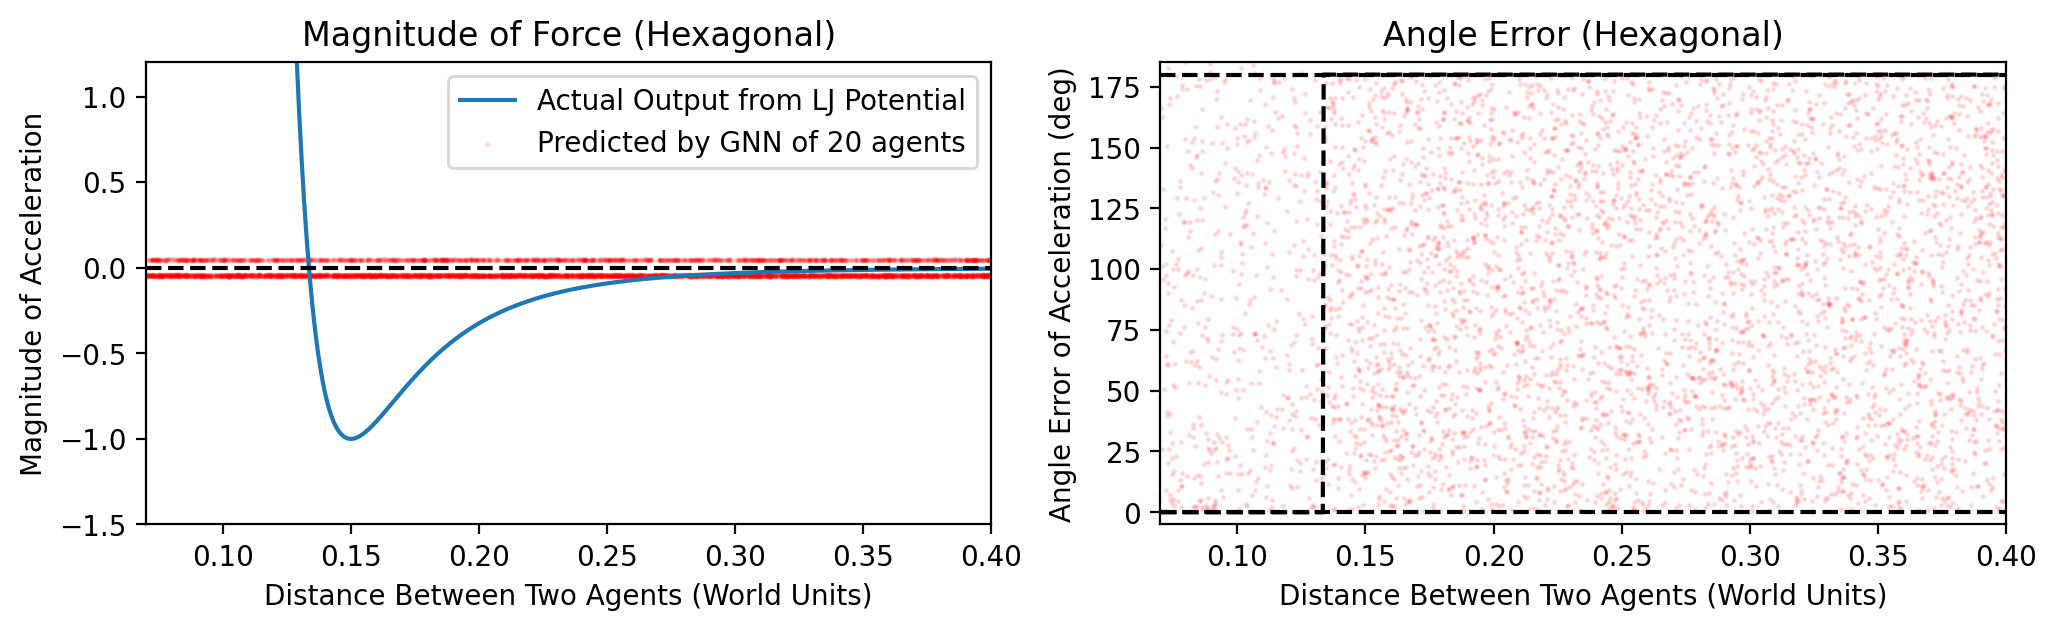

 13%|██████████████████████████                                                                                                                                                                         | 4/30 [39:30<4:20:05, 600.22s/it]

|D_loss|0.00047744158655405045	|G_loss|7.0350661277771


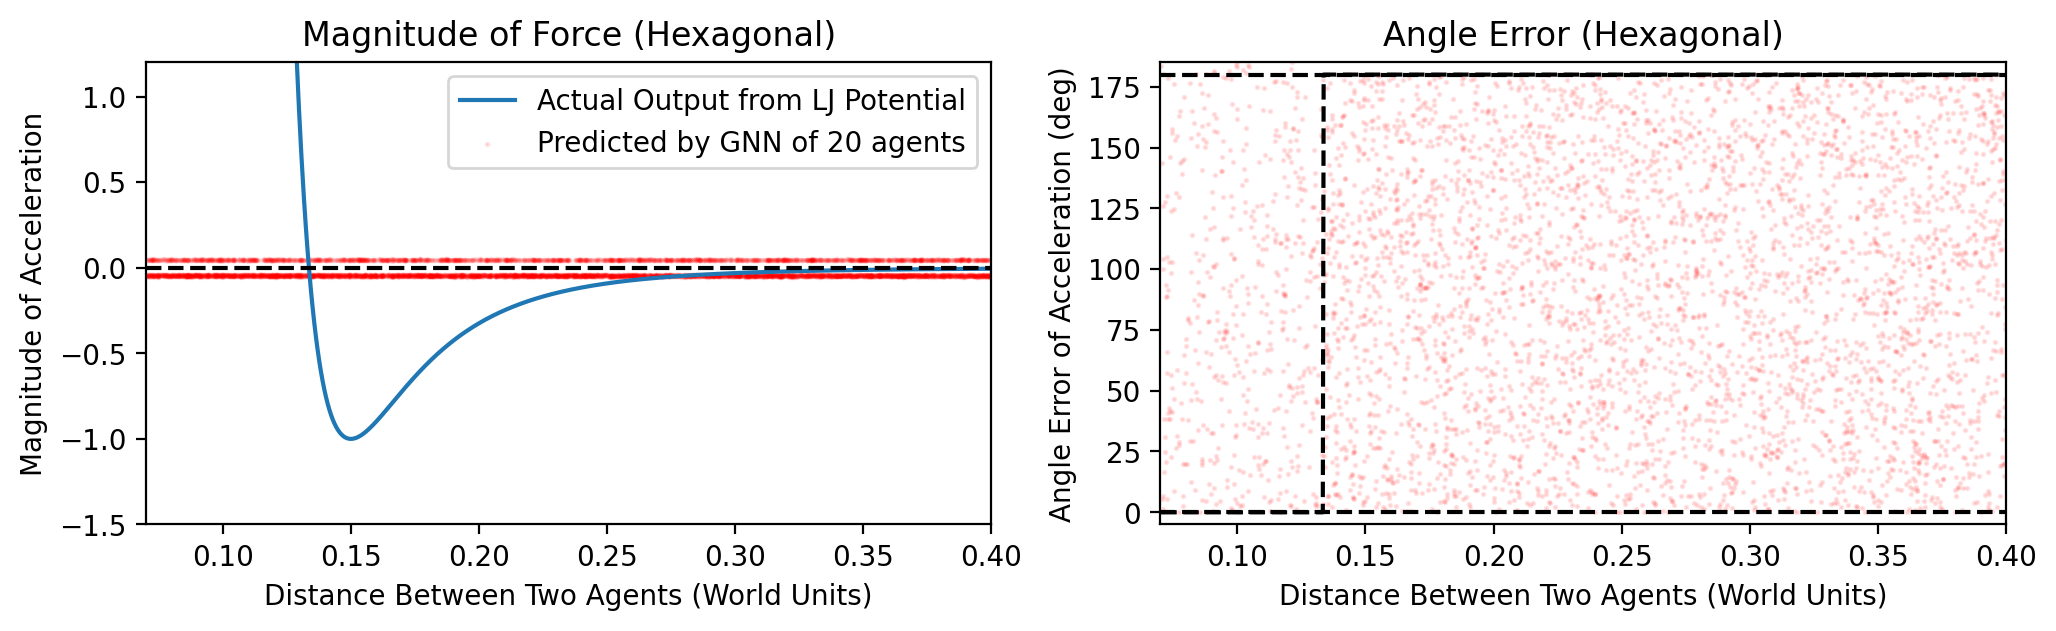

 17%|████████████████████████████████▌                                                                                                                                                                  | 5/30 [49:33<4:10:30, 601.21s/it]

|D_loss|0.002451737178489566	|G_loss|5.963933944702148


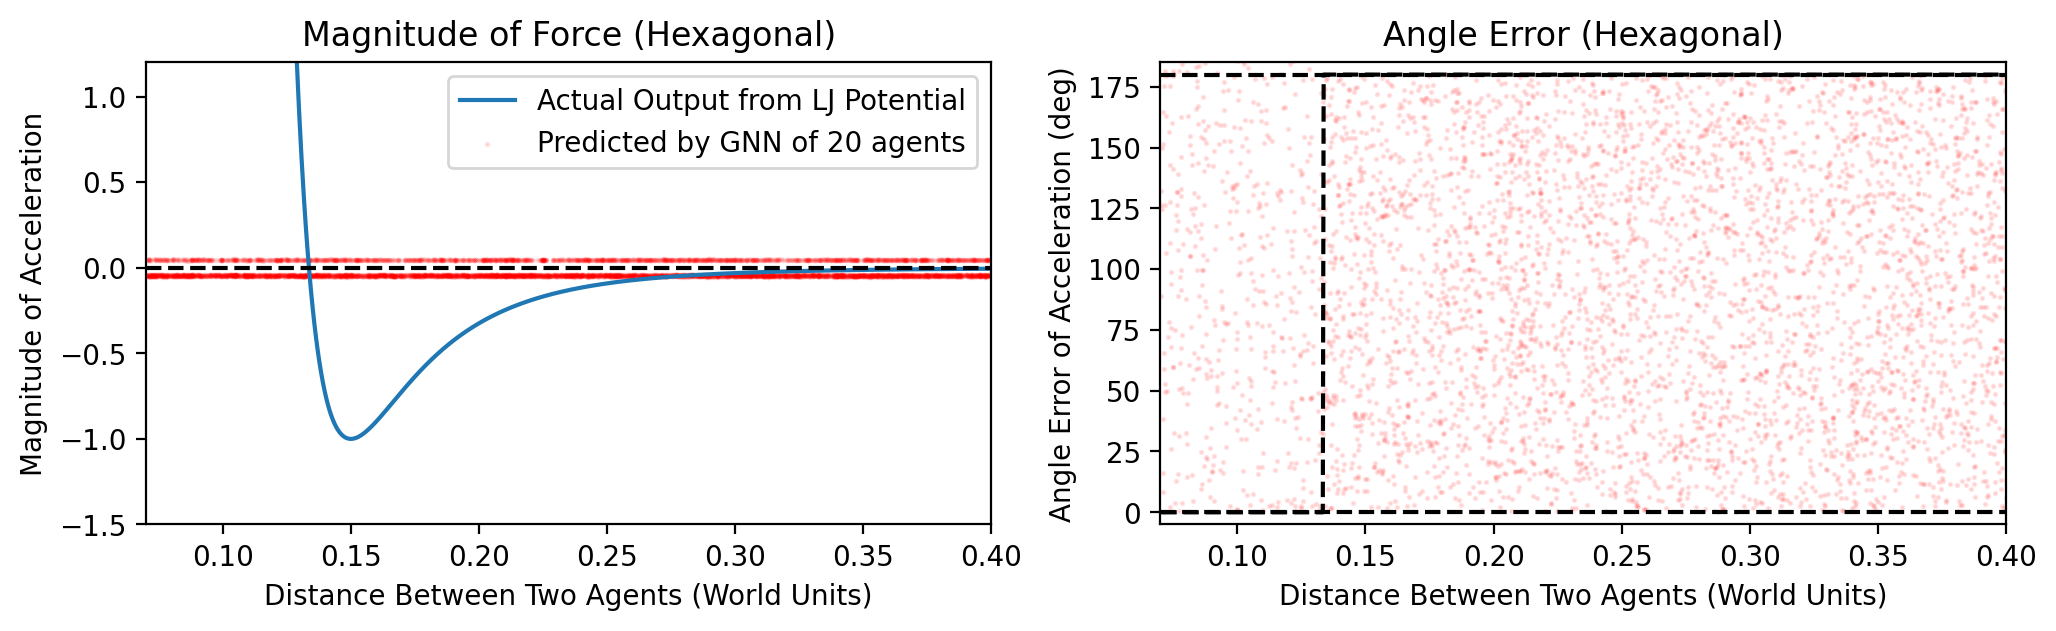

 20%|███████████████████████████████████████                                                                                                                                                            | 6/30 [58:00<3:47:37, 569.05s/it]

In [ ]:
num_epochs = 30

d_error=0
g_error=0

from tqdm import tqdm 

for epoch in tqdm(range(num_epochs)):
    
    for row in trainLoader:
        row.to(device)
        for _ in range(5):
            # 1. Train Generator
            g_optimizer.zero_grad()

            generated_y = G(row.x, row.edge_index, batch=row.batch)
            #print(generated_y)
            #print(generated_y.shape)
            gd_out      = D(row.x, generated_y.detach(), row.edge_index, batch=row.batch)
            #print(gd_out.shape)
            #print(gd_out)
            g_error     = loss(gd_out, torch.ones(gd_out.size()).to(device))

            g_error.backward()
            g_optimizer.step()

        # 2. Train Discriminator
        d_optimizer.zero_grad()
        
        true_d_out   = D(row.x, row.y, row.edge_index, batch=row.batch)
        false_d_out  = D(row.x, generated_y.detach(), row.edge_index, batch=row.batch)
        true_d_loss  = loss(true_d_out, torch.ones(true_d_out.size()).to(device))
        false_d_loss = loss(false_d_out, torch.zeros(false_d_out.size()).to(device))
        d_error      = (true_d_loss + false_d_loss) / 2
        
        d_error.backward()
        d_optimizer.step()
        
        # 3. Check
        #print(torch.cat([row.y, generated_y], dim=1))
    
    print("|D_loss|"+str(d_error.item())+"\t|G_loss|"+str(g_error.item()))
    showProgressGraphs(G)

In [ ]:
row.batch.shape

In [ ]:
false_d_out

In [ ]:
row.edge_index.shape

In [ ]:
row.y.shape

In [ ]:
gd_out

In [ ]:
from random import random

agents = [[random(), random()] for _ in range(5)]
datalist = []

for i in range(len(agents)):
    print("NEW GRAPH")
    focal = agents[i]
    graph_x = [[0, 0]]
    e1 = []
    e2 = []

    for j in range(len(agents)):
        neighbor = agents[j]
        if i == j:
            continue
        print("comparing agent ", i, "to agent", j)
        e1.extend([0, len(graph_x)])
        e2.extend([len(graph_x), 0])
        graph_x.append([neighbor[0]-focal[0], neighbor[1]-focal[1]])

    for x in graph_x:
        print(x)
    print(e1)
    print(e2)
    #graph_x = torch.tensor(graph_x, tensor.type=torch.float)
    #graph_e = torch.tensor([e1, e2], tensor.type=torch.long)
    #graph_y = torch.tensor(d2, tensor.type=torch.float)
    #datalist.append(Data(x=graph_x, edge_index=graph_e, y=graph_y))

print(agents)